# The Boston Marathon's Effect on Airbnb Listing Prices
### By: Eli Easton


## Introduction

## Data Cleaning & Loading

In [73]:
#! pip install -q matplotlib numpy pandas qeds

In [74]:
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds

#Change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

#Load calendar dataset
calendar = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\Boston\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)
#Clean "price column"
calendar["price"] = calendar["price"].astype(str).str.replace("$", "").str.replace(".00", 
                                                                                   "").str.replace(",", "").astype(float)
#Create "year_month" column from the "date" column in "df_calendar" dataset
calendar["date"] = pd.to_datetime(calendar["date"])
calendar["year_month"] = calendar["date"].dt.to_period("M")

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\Boston\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", "picture_url", "xl_picture_url", "host_id", 
                       "host_url", "host_name", "host_since", "host_location", "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", "host_listings_count", "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "neighbourhood", "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", "first_review", "last_review", 
                       "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", 
                       "review_scores_communication", "review_scores_location", "review_scores_value", "requires_license", 
                       "license", "jurisdiction_names", "instant_bookable", "cancellation_policy", 
                       "require_guest_profile_picture", "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", "security_deposit", "price", 
                       "number_of_reviews"], inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})
#Room type
for room in ["Entire home/apt", "Private room", "Shared room"]:
    listings[room] = listings["room_type"].map({room: 1}).fillna(0).astype(int)
#Property type
for property in ["Apartment", "House", "Condominium", "Townhouse", "Guesthouse", "Loft", "Villa", "Dorm", "Entire Floor", 
                 "Bed & Breakfast", "Boat", "Camper/RV", "Other"]:
    listings[property] = listings["property_type"].map({property: 1}).fillna(0).astype(int)
#Bed type
for bed in ["Real Bed", "Futon", "Pull-out Sofa", "Couch", "Airbed"]:
    listings[bed] = listings["bed_type"].map({bed: 1}).fillna(0).astype(int)
#Neighbourhood
for neighbourhood in ["Allston", "Back Bay", "Bay Village", "Beacon Hill", "Brighton", "Charlestown", "Chinatown", "Dorchester",
                      "Downtown", "East Boston", "Fenway", "Hyde Park", "Jamaica Plain", "Longwood Medical Area", 
                      "Leather District", "Mattapan", "Mission Hill", "North End", "Roslindale", "Roxbury", 
                      "South Boston", "South Boston Waterfront", "South End", "West End", "West Roxbury"]:
    listings[neighbourhood] = listings["neighbourhood_cleansed"].map({neighbourhood: 1}).fillna(0).astype(int)

#Merge datasets
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

#Load crime dataset
crime = pd.read_csv(r"C:\Users\eliea\Desktop\UofTYear3\Term_2\Eco225\ECO225Project\Data\crime.csv", encoding="latin1", 
                    low_memory=False)

#Clean "crime"
crime.drop(columns=["INCIDENT_NUMBER", "OFFENSE_CODE", "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", "SHOOTING", 
                    "DAY_OF_WEEK", "HOUR", "UCR_PART", "Lat", "Long", "STREET"], inplace=True)
crime["OCCURRED_ON_DATE"] = pd.to_datetime(crime["OCCURRED_ON_DATE"])
crime["year_month_crime"] = crime["OCCURRED_ON_DATE"].dt.to_period("M")

#Stack "cal_lis" and "crime" datasets
CalLisCrime = pd.concat([cal_lis, crime], axis = 0)

CalLisCrime


,id,date,available,price,year_month,host_is_superhost,host_total_listings_count,street,neighbourhood_cleansed,city,...,South Boston Waterfront,South End,West End,West Roxbury,OFFENSE_CODE_GROUP,OCCURRED_ON_DATE,YEAR,MONTH,Location,year_month_crime
0,3353.0,2017-09-05,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
1,3353.0,2017-09-04,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
2,3353.0,2017-09-03,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
3,3353.0,2017-09-02,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
4,3353.0,2017-09-01,t,36.0,2017-09,f,6.0,"Gardner St, Allston, MA 02134, United States",Allston,Allston,...,0.0,0.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327815,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Warrant Arrests,2016-06-05 17:25:00,2016.0,6.0,"(42.33695098, -71.08574813)",2016-06
327816,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Homicide,2015-07-09 13:38:00,2015.0,7.0,"(42.25592648, -71.12317207)",2015-07
327817,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Warrant Arrests,2015-07-09 13:38:00,2015.0,7.0,"(42.25592648, -71.12317207)",2015-07
327818,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Warrant Arrests,2016-05-31 19:35:00,2016.0,5.0,"(42.30233307, -71.11156487)",2016-05


## Summary Statistics Tables

In [75]:
#Generate Summary Statistics of price, bathrooms, bedrooms, beds, and review scores
summary_stats1 = CalLisCrime[["price", "bathrooms", "bedrooms", "beds", "review_scores_rating", 
                          "Superhost"]].describe().round(3)

summary_stats1.index = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
    "Median (50th Percentile)", "75th Percentile", "Maximum"]

clean_summary_stats1 = summary_stats1.style.set_caption("Table 1: Summary Statistics of Price and \
                                                         Key Controls").format("{:.3f}")


clean_summary_stats1


,price,bathrooms,bedrooms,beds,review_scores_rating,Superhost
Total Observations,643037.000,1303780.000,1305240.000,1305605.000,1011780.000,1308890.000
Mean,198.439,1.222,1.256,1.609,91.917,0.113
Standard Deviation,180.143,0.501,0.753,1.012,9.530,0.317
Minimum,11.000,0.000,0.000,0.000,20.000,0.000
25th Percentile,85.000,1.000,1.000,1.000,89.000,0.000
Median (50th Percentile),150.000,1.000,1.000,1.000,94.000,0.000
75th Percentile,255.000,1.000,2.000,2.000,98.250,0.000
Maximum,7163.000,6.000,5.000,16.000,100.000,1.000


In [76]:
#Generate summary stats of room type
summary_stats2 = CalLisCrime[["Entire home/apt", "Private room", "Shared room"]].describe().round(3)

summary_stats2.index = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
    "Median (50th Percentile)", "75th Percentile", "Maximum"]

clean_summary_stats2 = summary_stats2.style.set_caption("Table 1: Summary Statistics of Listings by Room \
                                                        Type").format("{:.3f}")

clean_summary_stats2

,Entire home/apt,Private room,Shared room
Total Observations,1308890.000,1308890.000,1308890.000
Mean,0.593,0.384,0.022
Standard Deviation,0.491,0.486,0.148
Minimum,0.000,0.000,0.000
25th Percentile,0.000,0.000,0.000
Median (50th Percentile),1.000,0.000,0.000
75th Percentile,1.000,1.000,0.000
Maximum,1.000,1.000,1.000


In [77]:
#Generate summary stats of property type
summary_stats3 = CalLisCrime[["Apartment", "House", "Condominium", "Townhouse", "Guesthouse", "Loft", "Villa", "Dorm", 
                          "Entire Floor", "Bed & Breakfast", "Boat", "Camper/RV", "Other"]].describe().round(3)

summary_stats3.index = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
    "Median (50th Percentile)", "75th Percentile", "Maximum"]

clean_summary_stats3 = summary_stats3.style.set_caption("Table 1: Summary Statistics of Listings by \
                                                        Property Type").format("{:.3f}")

clean_summary_stats3

,Apartment,House,Condominium,Townhouse,Guesthouse,Loft,Villa,Dorm,Entire Floor,Bed & Breakfast,Boat,Camper/RV,Other
Total Observations,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000,1308890.000
Mean,0.729,0.157,0.064,0.015,0.000,0.011,0.002,0.001,0.001,0.011,0.003,0.000,0.005
Standard Deviation,0.445,0.364,0.245,0.122,0.017,0.104,0.041,0.024,0.033,0.106,0.058,0.017,0.069
Minimum,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25th Percentile,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Median (50th Percentile),1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75th Percentile,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Maximum,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [78]:
#Generate summary stats of listings by neighbourhood
summary_stats4 = CalLisCrime[["Allston", "Back Bay", "Bay Village", "Beacon Hill", "Brighton", "Charlestown", "Chinatown", "Dorchester",
                      "Downtown", "East Boston", "Fenway", "Hyde Park", "Jamaica Plain", "Longwood Medical Area", 
                      "Leather District", "Mattapan", "Mission Hill", "North End", "Roslindale", "Roxbury", 
                      "South Boston", "South Boston Waterfront", "South End", "West End", "West Roxbury"]].describe().T.round(3)

summary_stats4.columns = ["Total Observations", "Mean", "Standard Deviation", "Minimum", "25th Percentile", 
    "Median (50th Percentile)", "75th Percentile", "Maximum"]

summary_stats4[["Total Observations", "Minimum", "Maximum"]] = summary_stats4[["Total Observations", "Minimum", "Maximum"]].astype(int)

clean_summary_stats4 = summary_stats4.style.set_caption("Table 1: Summary Statistics of Airbnb Listings by \
                                                        Neighbourhood").format("{:.3f}")

clean_summary_stats4




,Total Observations,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Allston,1308890.000,0.073,0.259,0.000,0.000,0.000,0.000,1.000
Back Bay,1308890.000,0.084,0.278,0.000,0.000,0.000,0.000,1.000
Bay Village,1308890.000,0.007,0.082,0.000,0.000,0.000,0.000,1.000
Beacon Hill,1308890.000,0.054,0.226,0.000,0.000,0.000,0.000,1.000
Brighton,1308890.000,0.052,0.221,0.000,0.000,0.000,0.000,1.000
Charlestown,1308890.000,0.031,0.173,0.000,0.000,0.000,0.000,1.000
Chinatown,1308890.000,0.020,0.139,0.000,0.000,0.000,0.000,1.000
Dorchester,1308890.000,0.075,0.263,0.000,0.000,0.000,0.000,1.000
Downtown,1308890.000,0.048,0.214,0.000,0.000,0.000,0.000,1.000
East Boston,1308890.000,0.042,0.200,0.000,0.000,0.000,0.000,1.000


## Plots, Histograms, and Figures

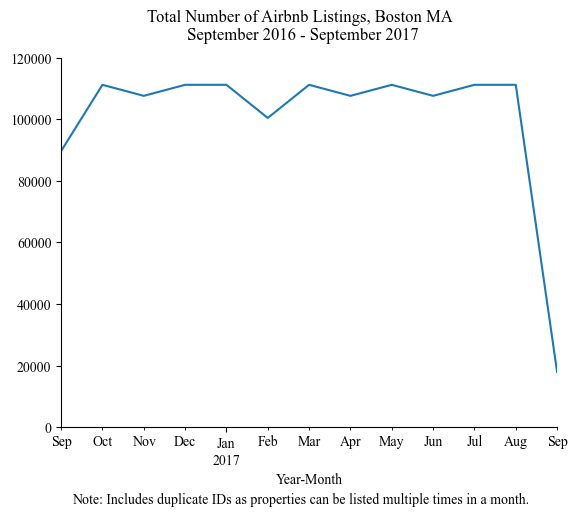

In [79]:
#1) Create a line plot of the total number of listings per year-month

#Count the total number of listings per month
total_listings = CalLisCrime.groupby("year_month")["id"].count().reset_index()
total_listings.rename(columns={"id":"total_listings"}, inplace=True)

#Create the line plot
#Create figure and plot space
fig, ax = plt.subplots()
#Plot the count of total listings by year-month
total_listings.plot(x="year_month", y="total_listings", kind="line", ax=ax, legend=False)

#Cleaning
#Create title and subtitle
fig.suptitle("Total Number of Airbnb Listings, Boston MA \n September 2016 - September 2017")
#Label x-axis
ax.set_xlabel("Year-Month")
#Remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#Set y ticks
ax.set_ylim(0, 120000)
#Create note under figure
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be listed multiple times in a month.", 
            ha="center", fontsize=10)
plt.show()

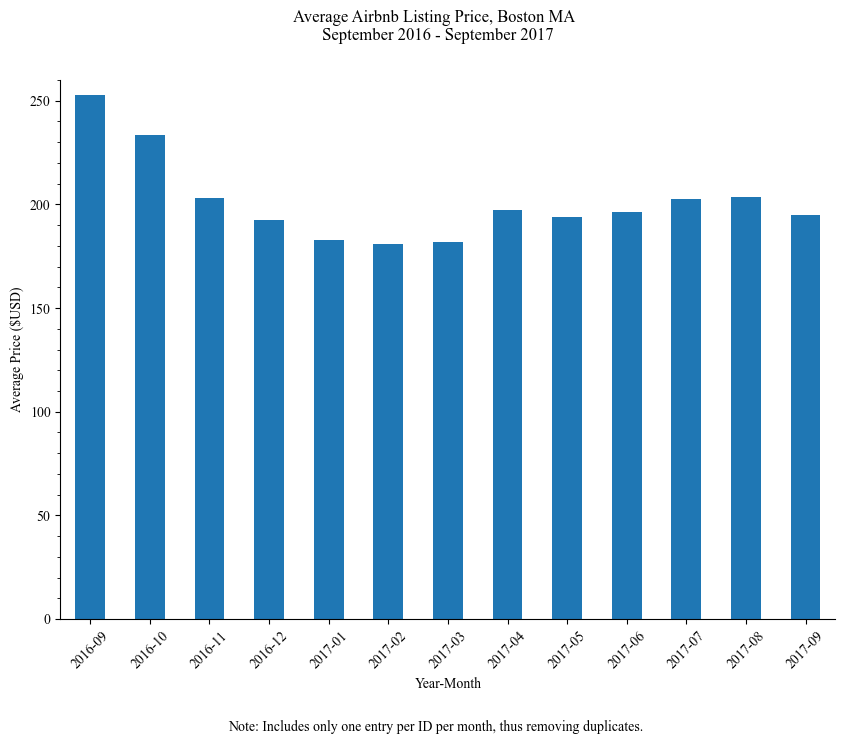

In [80]:
#2) Create a scatter plot of the average listing price per year-month

#Calculate the average listing price per month

#Calculate mean price per year-month
avg_list_price = CalLisCrime.groupby("year_month")["price"].mean().reset_index()
avg_list_price.rename(columns={"price":"avg_list_price"}, inplace=True)
#Convert "year_month" column to string
avg_list_price["year_month"] = avg_list_price["year_month"].astype(str)

#Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 7))
avg_list_price.plot(x="year_month", y="avg_list_price", kind="bar", ax=ax, legend=False)

#Cleaning
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)
fig.suptitle("Average Airbnb Listing Price, Boston MA \n September 2016 - September 2017")
ax.set_xlabel("Year-Month")
plt.xticks(rotation=45)
ax.set_ylabel("Average Price ($USD)")
ax.set_ylim(0, 260)
#Set y ticks to incriments of 10, where every 5th tick is major and labelled
ax.set_yticks(np.arange(0, 251, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  
plt.figtext(0.5, -0.05, "Note: Includes only one entry per ID per month, thus removing duplicates.", 
            ha="center", fontsize=10)
plt.show()

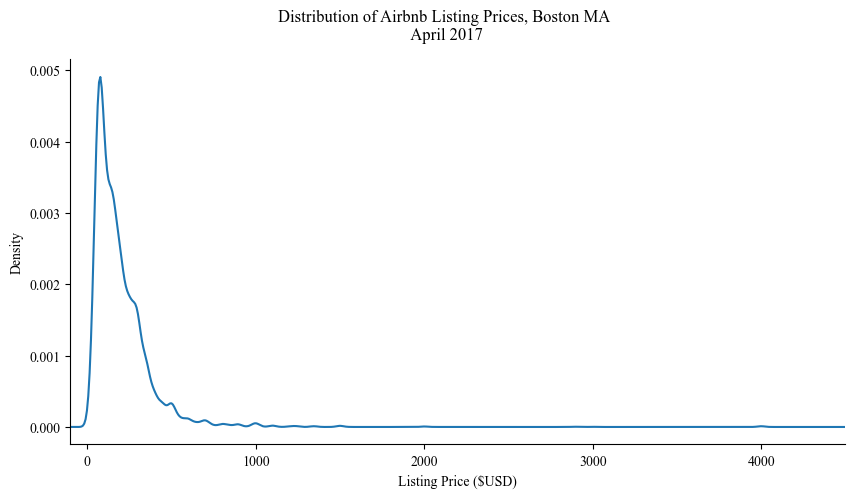

In [81]:
#3) Create a histogram of the distribution of listing prices for April 2017

#Create dataset for only April 2017
temp = CalLisCrime[CalLisCrime["year_month"] == "2017-04"]

#Create histogram
fig, ax = plt.subplots(figsize=(10, 5))
temp.plot.density(y="price", ax=ax, legend=False, xlim=(-100, 4500)) 

#Cleaning
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)
ax.set_ylabel("Density")
ax.set_xlabel("Listing Price ($USD)")
fig.suptitle("Distribution of Airbnb Listing Prices, Boston MA \n April 2017")
plt.show()

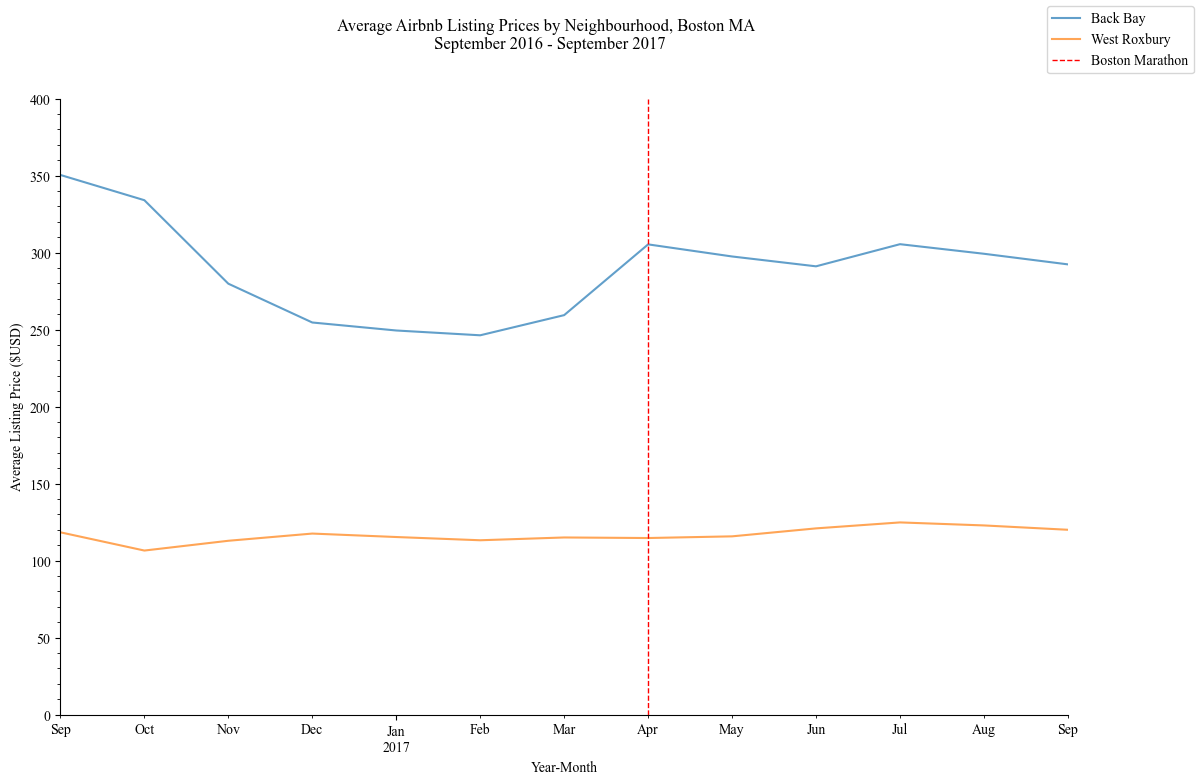

In [82]:
nei_price = CalLisCrime.groupby(["neighbourhood_cleansed", "year_month"])["price"].mean().reset_index()

nei_price_pivot = nei_price.pivot(index="year_month", columns="neighbourhood_cleansed",
                                  values="price")

nei_price_pivot.drop(columns=["Longwood Medical Area", "Leather District", "Chinatown",
                              "North End", "West End", "East Boston", "Hyde Park", "Bay Village",
                              "Mattapan", "South Boston Waterfront", "Allston", "Roslindale",
                              "Charlestown", "South Boston", "Brighton", "Mission Hill", "Beacon Hill",
                              "Dorchester", "Downtown", "Fenway", "Jamaica Plain", "Roxbury", "South End"], inplace=True)

fig, ax = plt.subplots(figsize=(13, 8))

nei_price_pivot.plot(ax=ax, alpha=0.7, legend=False)

ax.axvline(x="2017-04", color="red", linestyle="--", linewidth=1, label="Boston Marathon")

ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

ax.set_ylabel("Average Listing Price ($USD)")
ax.set_xlabel("Year-Month")
fig.suptitle("Average Airbnb Listing Prices by Neighbourhood, Boston MA \n September 2016 - September 2017")

ax.set_yticks(np.arange(0, 401, 50)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10)) 

fig.legend(loc="upper right")

plt.show()


## Conclusion

## Bibliography